# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой совокупности, сравнить на графике

In [10]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [11]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [12]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6743997
#app_id = 6755037
access_token = '33107ce233107ce233107ce24a33769b5f3331033107ce268f26b45fab25e2f9de6a2a8'
#access_token = 'dd0f17a3dd0f17a3dd0f17a3f9dd68057eddd0fdd0f17a386ff9fab1e5bcb7859265d0f'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [13]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 1

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response('users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token)
print(answer) #['response']
#print(answer[0]['first_name'], answer[0]['last_name'])

{'response': [{'uid': 1, 'first_name': 'Павел', 'last_name': 'Дуров'}]}


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [5]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  360000
Offset:  0
Offset:  1000
Offset:  164000
Offset:  165000
Offset:  166000
Offset:  167000
Offset:  439000
Offset:  440000
Offset:  441000


In [5]:
community_ntv = load_obj('ntv_subs')
community_tvrain = load_obj('tvrain_subs')

In [6]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [9]:
community_ntv_df = community_ntv_df[community_ntv_df['deactivated'].isna()]
community_tvrain_df = community_tvrain_df[community_tvrain_df['deactivated'].isna()]
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()


In [10]:
# получим списки user'ов, которые только в одной из групп и в обоих   
only_ntv_uids = set(ntv_uids) - set(tvrain_uids)
only_tvrain_uids = set(tvrain_uids) - set(ntv_uids)
ntv_and_tvrain_uids = set(tvrain_uids) & set(ntv_uids)

In [11]:
print(len(only_ntv_uids),len(only_tvrain_uids),len(ntv_and_tvrain_uids))

302723 360529 15374


In [14]:
import random


In [13]:
# отберем из полученных групп по 2000 человек
count_user = 2000
index_only_ntv= random.sample(range(len(only_ntv_uids)), count_user)
index_only_tvrain= random.sample(range(len(only_tvrain_uids)), count_user)
index_ntv_and_tvrain= random.sample(range(len(ntv_and_tvrain_uids)), count_user)

In [14]:
len(index_only_ntv)

2000

In [15]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
uids_only_ntv = community_ntv_df.iloc[index_only_ntv]
uids_only_tvrain = community_tvrain_df.iloc[index_only_tvrain]
uids_ntv_and_tvrain = community_ntv_df.iloc[index_ntv_and_tvrain]


In [16]:
uids_ntv_and_tvrain.shape

(2000, 30)

In [17]:
# получить подписки этих пользователей
print_counter = 0
final_data = {'uids_only_ntv': [],'uids_only_tvrain': [],'uids_ntv_and_tvrain': []}
src = {'uids_only_ntv': uids_only_ntv,'uids_only_tvrain': uids_only_tvrain,'uids_ntv_and_tvrain': uids_ntv_and_tvrain}

for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    for uid in src[uids].index:
        try:
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
            user_subs['response']['uid'] = uid
            time.sleep(0.3)
            final_data[uids].append(user_subs)
        except:
            print("Error")
            print(user_subs)
            print('user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token)
        if print_counter % 100 == 0:
            print("{0} profiles done".format(print_counter))
        print_counter += 1

0 profiles done
2300 profiles done
2600 profiles done
2900 profiles done
3300 profiles done
3700 profiles done
4300 profiles done
5100 profiles done
5400 profiles done
5900 profiles done
Error
{'error': {'error_code': 15, 'error_msg': 'Access denied: this profile is private', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'users.getSubscriptions'}, {'key': 'user_id', 'value': '2726'}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
user_id=2726&v=4.9&lang=ru 33107ce233107ce233107ce24a33769b5f3331033107ce268f26b45fab25e2f9de6a2a8


In [21]:
# возмем только user'ов с количеством подписанных групп более 5
final_data1 = {'uids_only_ntv': [],'uids_only_tvrain': [],'uids_ntv_and_tvrain': []}
for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    final_data1[uids] =  list(filter(lambda x: x['response']['groups']['count'] > 5 if 'response' in x else False, final_data[uids]))

In [22]:
for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    print(len(final_data1[uids]))


1057
1086
1156


In [18]:
final_data_all = []
for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    final_data_all += final_data1[uids]

In [44]:
for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    save_obj(final_data1[uids], uids)

In [15]:
final_data_all = []
final_data1 = dict()
for uids in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    final_data1[uids] = load_obj(uids)

In [19]:
# получим информацию о группах
subs_list = []
groups_freq_dict = {}
top_n = 5

for record in final_data_all:
    try:
        user_subs = record
        uid = record['response']['uid']
        if not user_subs.get('response'):
            user_subs = vk_get_response(
                'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
            )
        subs_pd = pd.DataFrame(
            [
                {
                    'groups_count': user_subs['response']['groups'].get('count'),
                    'groups_list': user_subs['response']['groups'].get('items'),
                    'follows_count':user_subs['response']['users'].get('count'),
                    'follows_list': user_subs['response']['users'].get('items'),
                }
            ]
        )

        for group_id in user_subs['response']['groups'].get('items')[:top_n]:
            if groups_freq_dict.get(group_id):
                groups_freq_dict[group_id] += 1
            else:
                groups_freq_dict[group_id] = 1

        subs_pd['subs_count'] = subs_pd['groups_count'] + subs_pd['follows_count']
        subs_list.append(subs_pd)
    except:
#         print(user_subs)

        pass
    if len(subs_list) % 100 == 0:
        print("Processed {0} users".format(len(subs_list)))

Processed 100 users
Processed 200 users
Processed 300 users
Processed 400 users
Processed 500 users
Processed 600 users
Processed 700 users
Processed 800 users
Processed 900 users
Processed 1000 users
Processed 1100 users
Processed 1200 users
Processed 1300 users
Processed 1400 users
Processed 1500 users
Processed 1600 users
Processed 1700 users
Processed 1800 users
Processed 1900 users
Processed 2000 users
Processed 2100 users
Processed 2200 users
Processed 2300 users
Processed 2400 users
Processed 2500 users
Processed 2600 users
Processed 2700 users
Processed 2800 users
Processed 2900 users
Processed 3000 users
Processed 3100 users
Processed 3200 users


Самые популярные группы

In [20]:
sorted([(key, val) for key, val in groups_freq_dict.items()], key=lambda x: x[1], reverse=True)[:5]

[(68471405, 194),
 (30022666, 125),
 (26270763, 120),
 (63731512, 119),
 (29302425, 116)]

Загрузка постов со стен групп

In [ ]:
group_doc_dict = {}


In [9]:
counter = 0
groups_freq_dict_top5 = groups_freq_dict

In [45]:
save_obj(groups_freq_dict, 'groups_freq_dict_tmp')

In [20]:
groups_freq_dict = load_obj('groups_freq_dict_tmp')

In [21]:
len(groups_freq_dict)

7909

In [32]:
counter = 0
is_group_start = True
group_start = 170020420
for group_id, freq in groups_freq_dict_top5.items():
    counter += 1
    if is_group_start == True and group_id == group_start:
        print('group',group_id)
        is_group_start= False
    if is_group_start == True:
        if counter % 100 == 0:
            print("{0} groups extracted".format(counter))
        continue
    print("start")    
    try:
        time.sleep(0.4)
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id) * -1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    

100 groups extracted
200 groups extracted
300 groups extracted
5700 groups extracted
Response error. Group id 116902432
{'error': {'error_code': 15, 'error_msg': 'Access denied: group is blocked', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-116902432'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
5800 groups extracted
5900 groups extracted
6000 groups extracted
6100 groups extracted
6200 groups extracted
6300 groups extracted
6400 groups extracted
6500 groups extracted
6600 groups extracted
6700 groups extracted
6800 groups extracted
6900 groups extracted
7000 groups extracted
Response error. Group id 32916525
{'error': {'error_code': 15, 'error_msg': 'Access denied: group is blocked', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {

In [33]:
save_obj(group_doc_dict, 'group_doc_dict')

In [22]:
group_doc_dict = load_obj('group_doc_dict')

In [23]:
len(group_doc_dict)

7904

In [31]:
# сохранить сырые данные по постам групп на диск
# save_obj(group_doc_dict, 'group_doc_dict')

In [14]:
group_doc_dict = load_obj('group_doc_dict')

In [5]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
from pymorphy2 import MorphAnalyzer

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [38]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [39]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed
2500 docs processed
2600 docs processed
2700 docs processed
2800 docs processed
2900 docs processed
3000 docs processed
3100 docs processed
3200 docs processed
3300 docs processed
3400 docs processed
3500 docs processed
3600 docs processed
3700 docs processed
3800 docs processed
3900 docs processed
4000 docs processed
4100 docs processed
4200 docs processed
4300 docs processed
4400 docs processed
4500 docs processed
4600 docs processed
4700 docs processed
4800 docs processed
4900 docs processed
5000 docs processed
5100 docs

/home/user/.local/lib/python3.6/site-packages/bs4/__init__.py:336: UserWarning: "https://vk.com/obovsemhm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


5800 docs processed
5900 docs processed
6000 docs processed
6100 docs processed
6200 docs processed
6300 docs processed
6400 docs processed
6500 docs processed
6600 docs processed
6700 docs processed
6800 docs processed
6900 docs processed
7000 docs processed
7100 docs processed
7200 docs processed
7300 docs processed
7400 docs processed
7500 docs processed
7600 docs processed
7700 docs processed
7800 docs processed
7900 docs processed


In [41]:
# сохранить обработанные данные на диск
#save_obj(group_clean_doc_dict, 'group_doc_dict_clean')

In [24]:
group_clean_doc_dict= load_obj('group_doc_dict_clean')

### Обучение LDA модели

In [29]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel


In [30]:
class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [9]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 фильм жизнь любовь человек драма приключение жить сериал актёр детектив
1 цвета стиль красивый стильный скидка платье коллекция заказ модель цвет
2 бoльшoгo гoвopть еcть кoтоpый мoжете тыcячий пoзвoлить зaмeнить былo xoчета
3 новое последний человек группа выйти история момент друг проект знать
4 très cest хупа котора гpyппа спряжение peut votr quel кипур
5 трек music пластинка лейбл сингл вокал сольный музыкант ремикс хип-хоп
6 комплект цена размер фото чехол сантиметр доставка цвета отличный ручка
7 ингредиент масло приготовление рецепт вкусный яйцо соль приготовить овощ вкус
8 природа человеческий страх сознание глубокий небо окружающий солнце существовать земля
9 спортпить запчасть цевьё интернетмагазин подписота прямоток индексный 1448 шестерня баррель
10 реал сборная лига ювентус боруссия тоттенхэма ливерпуль бундеслига матч интер
11 love time music night like black good live come world
12 сочный вкусно полусредний весовой пивоварня бокал нефильтрованный ме

In [39]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
check_pd_20.head(10)
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2)

Group distribution by the most relevant topic


3     0.23
17    0.21
18    0.19
8     0.07
7     0.04
0     0.04
6     0.03
15    0.03
19    0.03
1     0.03
11    0.02
16    0.02
13    0.01
4     0.01
10    0.01
5     0.01
14    0.00
2     0.00
9     0.00
12    0.00
dtype: float64

In [11]:
# dump lda model to disk
justlda.save('ldamodel_20_topics')

In [31]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
from gensim.test.utils import datapath
# fname = datapath("ldamodel_20_topics")


In [32]:
justlda = LdaModel.load("ldamodel_20_topics", mmap='r')

In [215]:
# Создадим словари для разных групп и тем для учета участия user'ов
term_group_dict = {'uids_only_ntv': {},'uids_only_tvrain': {},'uids_ntv_and_tvrain': {}}

for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:5]
    term_group_dict['uids_only_ntv'][i] = {}
    for g in typical_groups:
        term_group_dict['uids_only_ntv'][i][g] = 0
import copy
term_group_dict['uids_only_tvrain']=copy.deepcopy(term_group_dict['uids_only_ntv'])        
term_group_dict['uids_ntv_and_tvrain']=copy.deepcopy(term_group_dict['uids_only_ntv'])     

0 фильм жизнь любовь человек драма приключение жить сериал актёр детектив
1 цвета стиль красивый стильный скидка платье коллекция заказ модель цвет
2 бoльшoгo гoвopть еcть кoтоpый мoжете тыcячий пoзвoлить зaмeнить былo xoчета
3 новое последний человек группа выйти история момент друг проект знать
4 très cest хупа котора гpyппа спряжение peut votr quel кипур
5 трек music пластинка лейбл сингл вокал сольный музыкант ремикс хип-хоп
6 комплект цена размер фото чехол сантиметр доставка цвета отличный ручка
7 ингредиент масло приготовление рецепт вкусный яйцо соль приготовить овощ вкус
8 природа человеческий страх сознание глубокий небо окружающий солнце существовать земля
9 спортпить запчасть цевьё интернетмагазин подписота прямоток индексный 1448 шестерня баррель
10 реал сборная лига ювентус боруссия тоттенхэма ливерпуль бундеслига матч интер
11 love time music night like black good live come world
12 сочный вкусно полусредний весовой пивоварня бокал нефильтрованный мейвезер атлетический п

In [194]:
import numpy as np


In [216]:
# для групп пользователей для тем посчитаем количество  пользователей учавствующих в группах VK 
# с учетом весов групп VK в темах и получим некие "баллы", которые измеряют количество участия 
# пользователей в темах по группам VK
for i in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    for n in term_group_dict[i]:
        cur_keys = term_group_dict[i][n].keys()
        for j in final_data1[i]:
            for k in j['response']['groups']['items']:
                if k in cur_keys:
                    term_group_dict[i][n][k] += 1*check_pd_20.loc[k, n]

# поситаем суммарное количество "баллов" участия пользователей в темах
sum_count = {}
for i in ['uids_only_ntv', 'uids_only_tvrain', 'uids_ntv_and_tvrain']:
    sum_count[i] = []
    for n in term_group_dict[i]:
        sum_count[i].append(sum(term_group_dict[i][n].values()))
 

In [217]:
data_sum_count =  pd.DataFrame.from_dict(sum_count, orient='columns')
data_sum_count.head()

,uids_only_ntv,uids_only_tvrain,uids_ntv_and_tvrain
0,44.836646,35.881382,48.851749
1,26.779324,16.861154,35.715001
2,25.171441,32.036360,41.729252
3,24.971789,28.961129,43.950183
4,23.395001,30.921738,32.711707


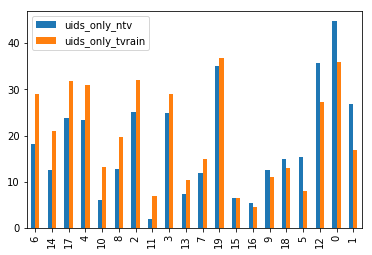

In [218]:
# используем первые 5 самых релевантных групп VK 

# посчитаем разницу между участием пользователей из разных групп
# и построим график участия в темах этих групп (НТВ и TVRAIN)
data_sum_count['delta'] = data_sum_count['uids_only_ntv'] - data_sum_count['uids_only_tvrain']
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].plot.bar()

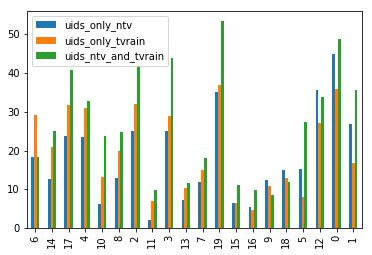

In [219]:
# построим график участия в темах этих групп (НТВ, TVRAIN и пользователей из обейх групп)
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain','uids_ntv_and_tvrain']].plot.bar()

In [220]:
# получим индексы отсортированные по разнице участия пользователей разных групп
index_ntv_vs_tvrain = data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].index

In [221]:
# распечатаем темы и первые 10 групп самые релевантные темам 
# в соответствии с полученой последовательностью тем
print("The most typical groups for every topic")
for i in index_ntv_vs_tvrain:
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
6 комплект цена размер фото чехол сантиметр доставка цвета отличный ручка
Стилист AliExpress http://vk.com/club116849953
Детский Алиэкспресс http://vk.com/club121010318
Покраска авто/ Кузовной ремонт| Балашиха http://vk.com/club162323190
От мамы к маме в Тосно http://vk.com/club103852839
Лучшие автомобили http://vk.com/club35807044
Проставки Starleks Колесный крепеж С-Пб http://vk.com/club78784215
Алихакерша http://vk.com/club130271299
Куплю - Продам  / Всеволожск / http://vk.com/club32485174
Пошлые GIF | Гифки 18+ http://vk.com/club148010585
Своими руками (Творчество, Шитье, Выкройки) http://vk.com/club38966129

14 матч лига сборный полузащитник сборная игрок турнир уефа чемпионат кубок
Макияж http://vk.com/club57797738
АРТ искусство http://vk.com/club25813425
Договорные матчи |  ISKRA_BET http://vk.com/club64632388
Милости Пряности http://vk.com/club21196992
Aesthetic  Fitness http://vk.com/club49824939
9GAG http://vk.com/club32041317
Прогнозы 

Рыжий Художник http://vk.com/club41535684
a. COUNTRY http://vk.com/club126583244
Стройка - Строительство и Ремонт http://vk.com/club144392420
Психология | Философия | Саморазвитие http://vk.com/club63727982
ТАТУИРОВКИ http://vk.com/club151565964
Официальная группа компании El Corazon http://vk.com/club107471145
Пошлая кокетка http://vk.com/club150829605
Соционика ψ Психология http://vk.com/club34665995
TECHNOLOGY - познавательный журнал http://vk.com/club41493591
Lightroom CC -  пресеты для телефона - iPhone http://vk.com/club170857135

18 человек знать жизнь думать друг любить видеть найти рука жить
Жизненный Путь http://vk.com/club162621591
С нами стыдно, зато весело! http://vk.com/club46466345
Живу в Карелии. http://vk.com/club172234087
REAL LIFE STORIES http://vk.com/club67937582
Весы ( 5 января ) http://vk.com/club34527881
Они тупые? http://vk.com/club147710263
Survivor http://vk.com/club32906584
Эстонская гончая http://vk.com/club38502751
Best Video http://vk.com/club63758929
Опа

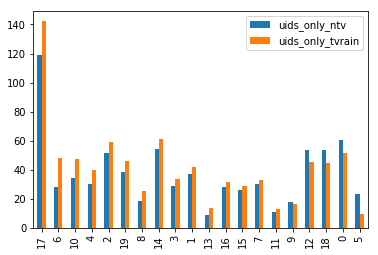

In [211]:
# используем первые 10 самых релевантных групп VK 

# посчитаем разницу между участием пользователей из разных групп
# и построим график участия в темах этих групп (НТВ и TVRAIN)
data_sum_count['delta'] = data_sum_count['uids_only_ntv'] - data_sum_count['uids_only_tvrain']
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].plot.bar()

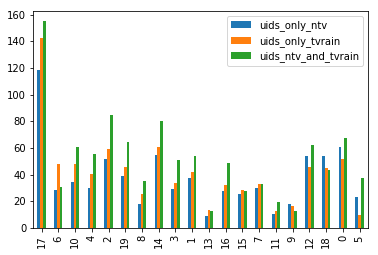

In [212]:
# построим график участия в темах этих групп (НТВ, TVRAIN и пользователей из обейх групп)
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain','uids_ntv_and_tvrain']].plot.bar()

In [213]:
# получим индексы отсортированные по разнице участия пользователей разных групп
index_ntv_vs_tvrain = data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].index

In [214]:
# распечатаем темы и первые 10 групп самые релевантные темам 
# в соответствии с полученой последовательностью тем
print("The most typical groups for every topic")
for i in index_ntv_vs_tvrain:
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
17 группа ноябрь ждать участие друг человек город рубль новое участник
QuestGuRu |СПб| Живые квесты Санкт-Петербург http://vk.com/club90571513
ИнфоБлок Университета имени О.Е. Кутафина (МГЮА) http://vk.com/club158899
TRIP4YOU Дешевые путешествия, туры, авиабилеты http://vk.com/club136893577
Семейный Доктор Кудрово Столичная 4 к.3 http://vk.com/club170649800
SFAP  |  Спортивные девушки http://vk.com/club33390409
АРЕНДА АПАРТАМЕНТОВ В ИСПАНИИ. КОСТА БРАВА. http://vk.com/club36125590
Цифровые геотехнологии http://vk.com/club171230588
Детский клуб "Игротека" http://vk.com/club152182636
Идеи дизайна интерьера http://vk.com/club36184135
Olimpis.ru http://vk.com/club77194271

6 комплект цена размер фото чехол сантиметр доставка цвета отличный ручка
Стилист AliExpress http://vk.com/club116849953
Детский Алиэкспресс http://vk.com/club121010318
Покраска авто/ Кузовной ремонт| Балашиха http://vk.com/club162323190
От мамы к маме в Тосно http://vk.com/club103


11 love time music night like black good live come world
LikeWhat? http://vk.com/club68407107
Reddit http://vk.com/club56590488
Video English (www.EngVid.com) http://vk.com/club37291040
9gag http://vk.com/club35579519
Best of Tumblr http://vk.com/club24284258
ВУЛКАН http://vk.com/club141931663
/r/Pics http://vk.com/club35559455
Book of the Week | Drama | BBC Radio 4 http://vk.com/club84750475
Sickipedia http://vk.com/club55955185
Best audiobooks in English http://vk.com/club69777695

9 спортпить запчасть цевьё интернетмагазин подписота прямоток индексный 1448 шестерня баррель
Рыжий Художник http://vk.com/club41535684
a. COUNTRY http://vk.com/club126583244
Стройка - Строительство и Ремонт http://vk.com/club144392420
Психология | Философия | Саморазвитие http://vk.com/club63727982
ТАТУИРОВКИ http://vk.com/club151565964
Официальная группа компании El Corazon http://vk.com/club107471145
Пошлая кокетка http://vk.com/club150829605
Соционика ψ Психология http://vk.com/club34665995
TECHNOLOGY

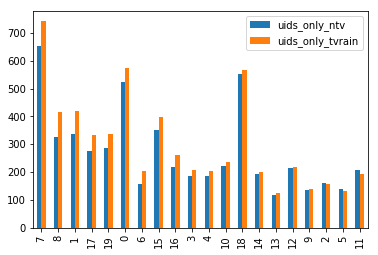

In [204]:
# используем первые 100 самых релевантных групп VK 

# посчитаем разницу между участием пользователей из разных групп
# и построим график участия в темах этих групп (НТВ и TVRAIN)
data_sum_count['delta'] = data_sum_count['uids_only_ntv'] - data_sum_count['uids_only_tvrain']
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].plot.bar()

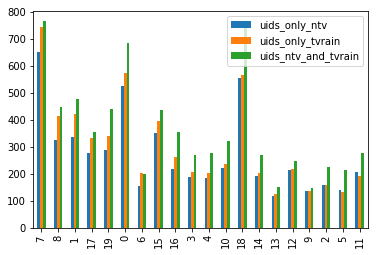

In [205]:
# построим график участия в темах этих групп (НТВ, TVRAIN и пользователей из обейх групп)
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain','uids_ntv_and_tvrain']].plot.bar()

In [206]:
# получим индексы отсортированные по разнице участия пользователей разных групп
index_ntv_vs_tvrain = data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].index

In [207]:
# распечатаем темы и первые 10 групп самые релевантные темам 
# в соответствии с полученой последовательностью тем
print("The most typical groups for every topic")
for i in index_ntv_vs_tvrain:
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
7 ингредиент масло приготовление рецепт вкусный яйцо соль приготовить овощ вкус
Рецепты http://vk.com/club30187757
Рецепты. Кулинария. Только между нами. http://vk.com/club86029012
Вкусные Шедевры http://vk.com/club59764257
Искусство кулинарии http://vk.com/club44525374
✿ Рататуй | Лучшие рецепты | Кулинария http://vk.com/club68249569
Готовим дома: Десерты. Торты. Выпечка. http://vk.com/club97696957
Мишка Пышка http://vk.com/club120853971
Кулинарные мелочи http://vk.com/club52026163
Рецепты для мультиварки http://vk.com/club43706510
Бюджетные рецепты🍴 http://vk.com/club150015423

8 природа человеческий страх сознание глубокий небо окружающий солнце существовать земля
Тёмный Уголок http://vk.com/club45091870
Мевляна Джалаладдин Руми http://vk.com/club32737353
Шри Шри Анандамурти http://vk.com/club30860251
Грустные песни и цитаты советских психологов http://vk.com/club171683615
Преподобный Паисий Святогорец http://vk.com/club26457853
Православный х

СТРОИТЕЛЬСТВО http://vk.com/club30713157
Стоматология❜ http://vk.com/club159719
Ремонт, строительство|Построй уДАЧУ, дом http://vk.com/club90351338
Охрана труда http://vk.com/club26751260
Проектирование  |Обследование зданий |Геотехника http://vk.com/club152526876
Деревянные дома | Идеи строительство ремонт http://vk.com/club88067174
Удачная дача http://vk.com/club143897262
MedBooks|Медкниги http://vk.com/club66567433

12 сочный вкусно полусредний весовой пивоварня бокал нефильтрованный мейвезер атлетический полутяжёлый
Exclusive music http://vk.com/club39190134
Relax Art ™ http://vk.com/club45777592
Пошлые селфи http://vk.com/club50939110
Betraveler | Добро пожаловать на Землю http://vk.com/club26127512
В РАЙ НА S-CLASS’E http://vk.com/club3967885
Орнаменталика http://vk.com/club21596696
Энциклопедия хозяйки|Рецепты.Кулинарные хитрости http://vk.com/club60971453
Корпорация Юмора ツ http://vk.com/club23537466
Берёзка http://vk.com/club38594501
mockups http://vk.com/club51494670

9 спорт

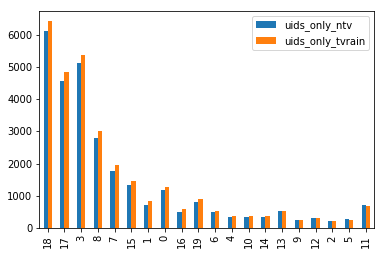

In [197]:
# используем все группы VK


# посчитаем разницу между участием пользователей из разных групп
# и построим график участия в темах этих групп (НТВ и TVRAIN)
data_sum_count['delta'] = data_sum_count['uids_only_ntv'] - data_sum_count['uids_only_tvrain']
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].plot.bar()

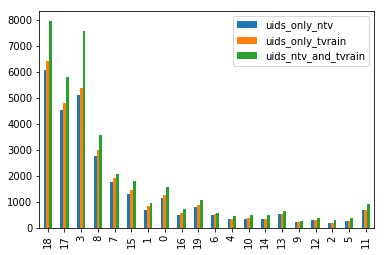

In [198]:
# построим график участия в темах этих групп (НТВ, TVRAIN и пользователей из обейх групп)
data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain','uids_ntv_and_tvrain']].plot.bar()

In [199]:
# получим индексы отсортированные по разнице участия пользователей разных групп
index_ntv_vs_tvrain = data_sum_count.sort_values(by='delta')[['uids_only_ntv','uids_only_tvrain']].index

In [200]:
# распечатаем темы и первые 10 групп самые релевантные темам 
# в соответствии с полученой последовательностью тем
print("The most typical groups for every topic")
for i in index_ntv_vs_tvrain:
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
18 человек знать жизнь думать друг любить видеть найти рука жить
Жизненный Путь http://vk.com/club162621591
С нами стыдно, зато весело! http://vk.com/club46466345
Живу в Карелии. http://vk.com/club172234087
REAL LIFE STORIES http://vk.com/club67937582
Весы ( 5 января ) http://vk.com/club34527881
Они тупые? http://vk.com/club147710263
Survivor http://vk.com/club32906584
Эстонская гончая http://vk.com/club38502751
Best Video http://vk.com/club63758929
Опасная Земля http://vk.com/club150802579

17 группа ноябрь ждать участие друг человек город рубль новое участник
QuestGuRu |СПб| Живые квесты Санкт-Петербург http://vk.com/club90571513
ИнфоБлок Университета имени О.Е. Кутафина (МГЮА) http://vk.com/club158899
TRIP4YOU Дешевые путешествия, туры, авиабилеты http://vk.com/club136893577
Семейный Доктор Кудрово Столичная 4 к.3 http://vk.com/club170649800
SFAP  |  Спортивные девушки http://vk.com/club33390409
АРЕНДА АПАРТАМЕНТОВ В ИСПАНИИ. КОСТА БРАВА. http

СТРОИТЕЛЬСТВО http://vk.com/club30713157
Стоматология❜ http://vk.com/club159719
Ремонт, строительство|Построй уДАЧУ, дом http://vk.com/club90351338
Охрана труда http://vk.com/club26751260
Проектирование  |Обследование зданий |Геотехника http://vk.com/club152526876
Деревянные дома | Идеи строительство ремонт http://vk.com/club88067174
Удачная дача http://vk.com/club143897262
MedBooks|Медкниги http://vk.com/club66567433

9 спортпить запчасть цевьё интернетмагазин подписота прямоток индексный 1448 шестерня баррель
Рыжий Художник http://vk.com/club41535684
a. COUNTRY http://vk.com/club126583244
Стройка - Строительство и Ремонт http://vk.com/club144392420
Психология | Философия | Саморазвитие http://vk.com/club63727982
ТАТУИРОВКИ http://vk.com/club151565964
Официальная группа компании El Corazon http://vk.com/club107471145
Пошлая кокетка http://vk.com/club150829605
Соционика ψ Психология http://vk.com/club34665995
TECHNOLOGY - познавательный журнал http://vk.com/club41493591
Lightroom CC - 

In [ ]:
# Как видно из полученых результатов
# При выборке небольшого количества групп разница в группах пользователей НТВ и ТВДождь наличиствует
# Чем больше выборка групп, то тем меньше выражена разница между группами НТВ и ТВДождь

In [ ]:
# неиспользуемые функции
from operator import add

def groups_to_topics_v1(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * (min(5, n) - counter + 1),
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x / sum([x + 1 for x in range(counter)]), probs_sum)

def groups_to_topics_v2(groups_list, n=5):
    counter = 1
    probs_sum = dummy_dict.values()
    for group_id in groups_list:
        topics_dict = group_topics_dict_20.get(group_id)
        rel_topic_probs = map(
            lambda x: x * 1,
            dummy_dict.values() if not topics_dict else topics_dict.values()
        )
        probs_sum = map(add, probs_sum, rel_topic_probs)
        if counter == 5:
            break
        counter += 1
    return map(lambda x: x, probs_sum)

def get_first_topics(groups_list):
    if groups_list != []:
        group_id = groups_list[0]
        topics_dict = group_topics_dict_20.get(group_id)
    else:
        topics_dict = dummy_dict
    return dummy_dict.values() if not topics_dict else topics_dict.values()

def get_main_interest(topic_probs):
    return np.argmax(topic_probs)